In [1]:
import sys
sys.path.append('/global/homes/j/jpiat/shared_code/abacus_mocks/')

import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from hodpy.cosmology import CosmologyAbacus
from pycorr import TwoPointCorrelationFunction

cosmo = CosmologyAbacus(0)  #c000 cosmology

In [2]:
box_file = '/pscratch/sd/a/amjsmith/AbacusSummit/secondgen_new/z0.200/AbacusSummit_base_c000_ph000/BGS_box_S.fits'
box_file_jp = '/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph000/cubic_box/BGS_box_S.fits'

box_cat = fits.open(box_file)
box = Table(box_cat[1].data)
box_cat.close()

box_cat = fits.open(box_file_jp)
box_jp = Table(box_cat[1].data)
box_cat.close()

In [3]:
z = 0.2
a = 1/(1+z)
H = cosmo.H(z)
h = cosmo.H(0)/100

box['x_rsd'] = box['x'] + box['vx']/(a*H/h)
pos = box['x_rsd','y','z']

box_jp['x_rsd'] = box_jp['x'] + box_jp['vx']/(a*H/h)
pos_jp = box_jp['x_rsd','y','z']

In [4]:
M = box['R_MAG_ABS']
M_jp = box_jp['R_MAG_ABS']

M_bins = np.arange(-22,-17.5,0.5)

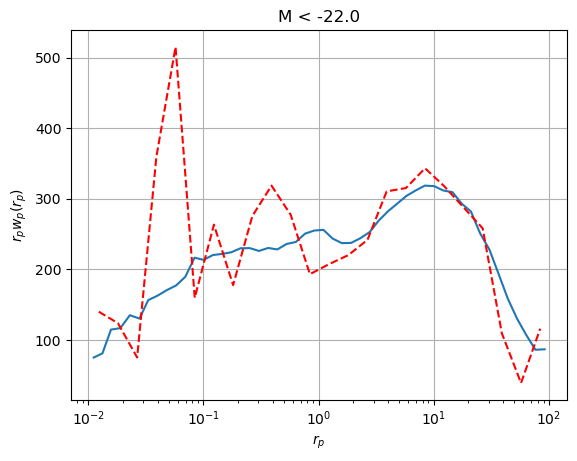

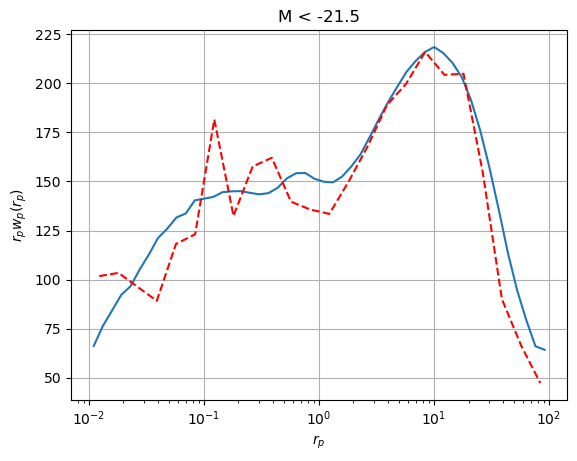

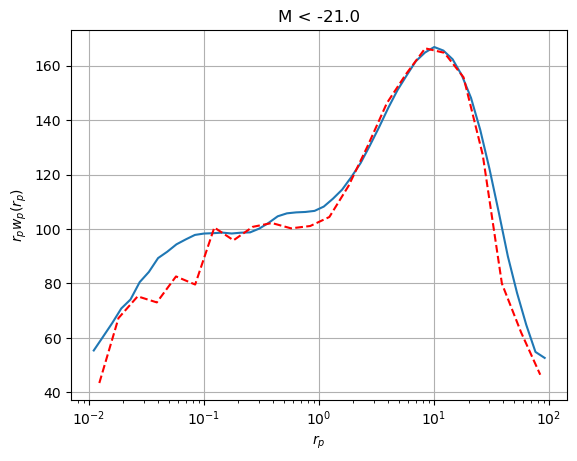

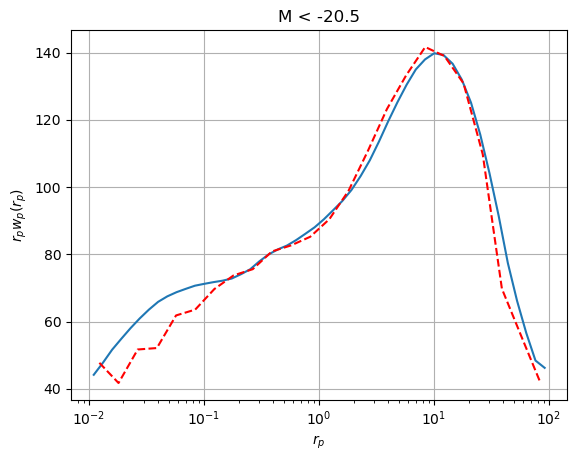

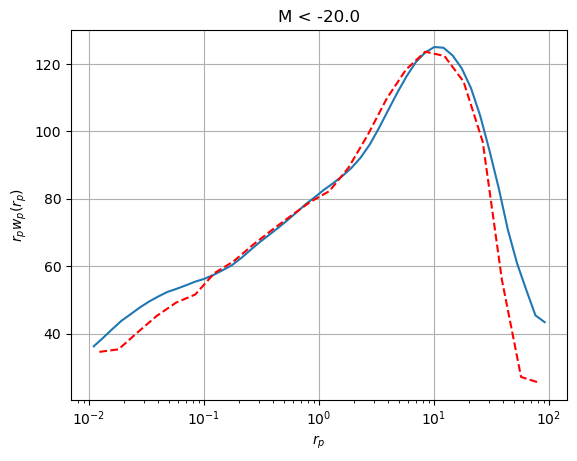

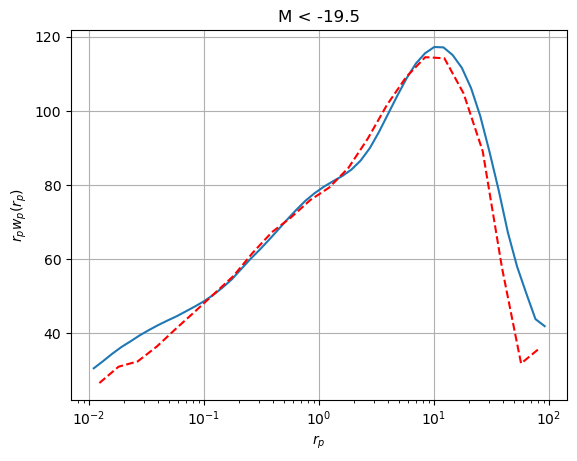

In [ ]:
wp_y1 = np.loadtxt('wp_target_y1_pip_ang_wsys_pi80.dat')
wp_y1[:,0]


for i in range(len(M_bins)):

    inside = M<=M_bins[i]
    
    posM = pos[inside]
    pos_arr = np.array([posM['x_rsd'],posM['y'],posM['z']])
    
    edges = (np.logspace(-2, 2, 51), np.linspace(-80, 80, 161))
    result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr, engine='corrfunc', nthreads=4)
    sep, wp = result(pimax=None, return_sep=True)

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_title(f'M < {M_bins[i]}')
    ax.plot(sep, sep * wp)
    ax.plot(wp_y1[:,0], wp_y1[:,0] * wp_y1[:,i+1],'r--')
    ax.set_xlabel(r'$r_{p}$')
    ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
    ax.grid(True)

In [ ]:
wp_hod = np.loadtxt('diff_start_low_prior_1_CF_wsys.txt')
wp_hod[:,0]


for i,threshold in enumerate(M_bins):

    inside = M<=threshold
    
    posM = pos[inside]
    pos_arr = np.array([posM['x_rsd'],posM['y'],posM['z']])

    edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
    result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr, engine='corrfunc', nthreads=4)
    sep, wp = result(pimax=None, return_sep=True)

    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_title(f'M < {threshold}')
    ax.plot(sep, sep * wp)
    ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,i+1],'r--')
    ax.set_xlabel(r'$r_{p}$')
    ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
    ax.grid(True)
    plt.show()


Received signal = `Interrupt' (signo = 2). Aborting 


RuntimeError: RuntimeError occurred

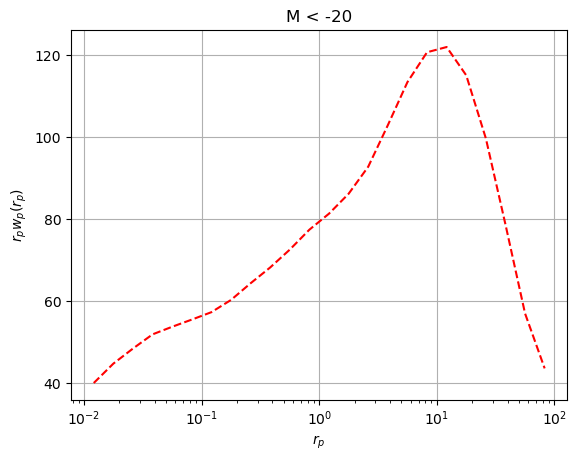

In [6]:
wp_hod = np.loadtxt('diff_start_low_prior_1_CF_wsys.txt')

ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < -20')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,5],'r--',label='best-fitting HOD')


posM = pos[M<=-20]
pos_arr = np.array([posM['x_rsd'],posM['y'],posM['z']])

posM_jp = pos_jp[M_jp<=-20]
pos_arr_jp = np.array([posM_jp['x_rsd'],posM_jp['y'],posM_jp['z']])

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr, engine='corrfunc', nthreads=4)
sep, wp = result(pimax=None, return_sep=True)

print("Projected correlation function for Alex's mock")

ax.plot(sep, sep * wp,label="Alex's mock")

result1 = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr_jp, engine='corrfunc', nthreads=4)
sep1, wp1 = result1(pimax=None, return_sep=True)

ax.plot(sep1, sep1 * wp1, ls='-.', label="Jade's mock")

plt.legend()
plt.show()

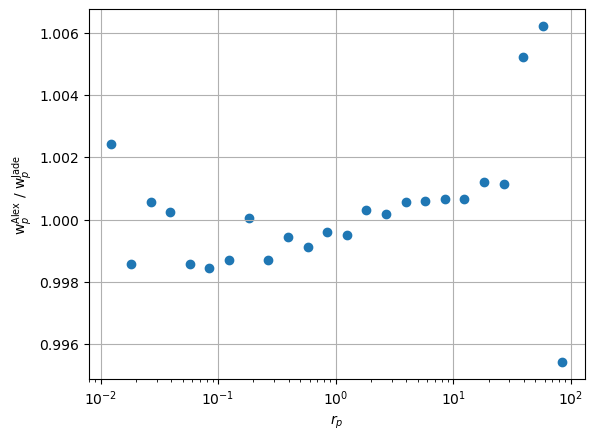

In [25]:
plt.figure()
plt.grid()
plt.xscale('log')
plt.scatter(sep,wp/wp1)
plt.ylabel(r'w$_p^{\rm Alex}$ / w$_p^{\rm Jade}$')
plt.xlabel(r'$r_{p}$')
plt.show()

In [5]:
wp_hod = np.loadtxt('diff_start_low_prior_1_CF_wsys.txt')
box_file2 = '/pscratch/sd/j/jpiat/Abacus_mocks/z0.200/AbacusSummit_base_c000_ph006/cubic_box/BGS_box_S.fits'

box_cat = fits.open(box_file)
box2 = Table(box_cat[1].data)
box_cat.close()

z = 0.2
a = 1/(1+z)
H = cosmo.H(z)
h = cosmo.H(0)/100

box2['x_rsd'] = box2['x'] + box2['vx']/(a*H/h)
pos2 = box2['x_rsd','y','z']

M2 = box2['R_MAG_ABS']

posM1 = pos_jp[M_jp<=-20]
pos_arr1 = np.array([posM1['x_rsd'],posM1['y'],posM1['z']])

posM2 = pos2[M2<=-20]
pos_arr2 = np.array([posM2['x_rsd'],posM2['y'],posM2['z']])

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result1 = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr1, engine='corrfunc', nthreads=4)
sep1, wp1 = result1(pimax=None, return_sep=True)

edges = (np.logspace(-2, 2, 25), np.linspace(-80, 80, 161))
result2 = TwoPointCorrelationFunction('rppi', edges, boxsize=2000, position_type = 'xyz', los='x', data_positions1=pos_arr2, engine='corrfunc', nthreads=4)
sep2, wp2 = result2(pimax=None, return_sep=True)

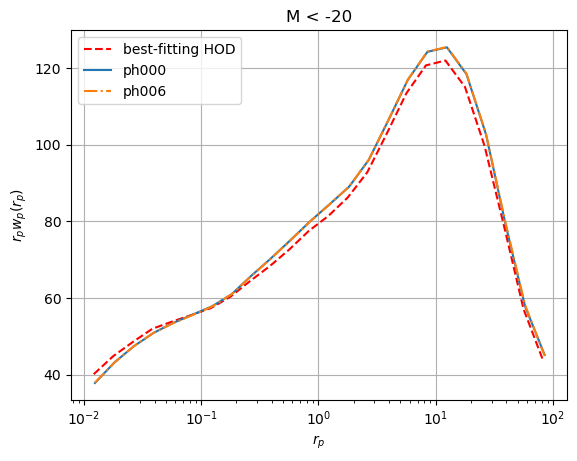

In [7]:
ax = plt.gca()
ax.set_xscale('log')
ax.set_title(f'M < -20')
ax.set_xlabel(r'$r_{p}$')
ax.set_ylabel(r'$r_{p} w_{p}(r_{p})$')
ax.grid(True)
ax.plot(wp_hod[:,0], wp_hod[:,0] * wp_hod[:,5],'r--',label='best-fitting HOD')
ax.plot(sep1, sep1 * wp1, ls='-', label="ph000")
ax.plot(sep2, sep2 * wp2, ls='-.', label="ph006")
plt.legend()
plt.show()

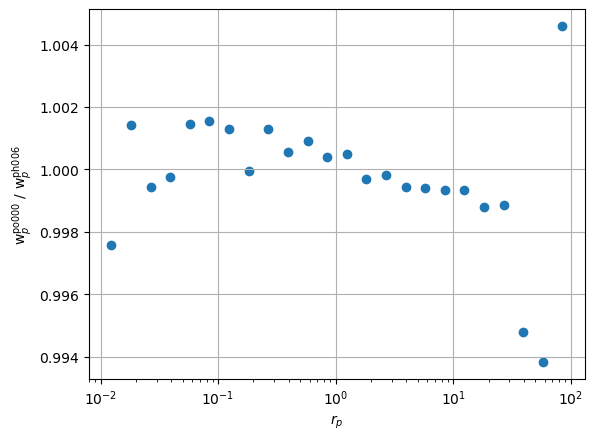

In [8]:
plt.figure()
plt.grid()
plt.xscale('log')
plt.scatter(sep1,wp1/wp2)
plt.ylabel(r'w$_p^{\rm po000}$ / w$_p^{\rm ph006}$')
plt.xlabel(r'$r_{p}$')
plt.show()